# Комментарий наставника
Привет! Все отлично. 
Я написал один небольшой комментарий по ходу работы, но это скорее подсказка-пожелание. 

Я очень рад, что ты заменил tbd на nan и что не стал менять na-значения хоть на что-либо. А просто вовремя исключил их из рассмотрения

## 0. Описание проекта
Вы работаете в компании, которая осуществляет продажу компьютерных игр через интернет-магазин и в сети офлайн магазинов. Одно из ключевых преимуществ компаний — это анализ данных при планировании закупок и рекламных компаний. Ваша задача проанализировать накопленные данные о продажах в разные года, определить тренды и проверить гипотезы. Ваш основной результат — итоговая рекомендация руководству компании о том, на каких играх стоит сосредоточиться в будущем году.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## 1. Общая информация

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# данные о продажах в разные года
games_data = pd.read_csv ('/datasets/games_data.csv')

# данные о возрастном рейтинге ESRB
rating = pd.read_csv ('/datasets/rating.csv')

Описание данных:

- platform — платформа;
- sales_year — год продажи;
- genre — жанр игры;
- online — количество продаж (в сотнях тысяч);
- offline — количество продаж (в сотнях тысяч);
- critic_score — оценка критиков (максимум 100);
- user_score — оценка пользователей (максимум 10);
- rating — возрастной рейтинг ESRB;
- game_id — id игры.

In [2]:
# выведем информацию о наборе данных
games_data.info()
 
# и первые строки датасета
games_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4026 entries, 0 to 4025
Data columns (total 9 columns):
platform        4026 non-null object
sales_year      4026 non-null float64
genre           4026 non-null object
online          4026 non-null float64
offline         4026 non-null float64
critic_score    1812 non-null float64
user_score      2382 non-null object
rating          2315 non-null object
game_id         4026 non-null int64
dtypes: float64(4), int64(1), object(4)
memory usage: 283.2+ KB


,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id
0,PS3,2017.0,Action,702.0,909.0,97.0,8.2,M,20838
1,X360,2017.0,Action,966.0,514.0,97.0,8.1,M,48673
2,X360,2017.0,Shooter,904.0,424.0,88.0,3.4,M,17801
3,PS4,2015.0,Shooter,603.0,586.0,NaN,NaN,NaN,12200
4,3DS,2017.0,Role-Playing,528.0,419.0,NaN,NaN,NaN,11432


In [3]:
rating.info()
rating

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
rating_type    8 non-null object
decryption     8 non-null object
dtypes: object(2)
memory usage: 208.0+ bytes


,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)
5,AO,Только для взрослых
6,EC,Для детей младшего возраста
7,RP,Рейтинг ожидается


## 2. Подготовка данных
- Посчитайте общее количество продаж и запишите в отдельный столбец.
- Приведите данные к нужным типам:
    - опишите, в каких столбцах пришлось заменить тип данных и почему
- Обработайте пропуски при необходимости:
    - если вы решили заполнить пропуски определённым образом или не заполнять совсем — объясните, почему;
    - опишите возможные причины возникновения пропусков;
    - обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать.

In [4]:
# изменим названия столбцов
change_column_names_dict = {"online": "sales_online", \
                            "offline": "sales_offline"}
games_data = games_data.rename(columns = change_column_names_dict)

In [5]:
# добавим столбец с общим количеством продаж (в сотнях тысяч)
games_data['sales_overall'] = games_data.sales_online + games_data.sales_offline

Удалим (заменим на NaN) значения 'tbd' в столбце 'user_score', поскольку эти значения не дают никакой дополнительной информации и всё ещё являются неизвестными.

Остальные пропуски ('critic_score', 'user_score', 'raiting') нельзя заполнить, используя значения других столбцов, поэтому оставим их без изменений.

In [6]:
games_data[games_data['user_score'] == 'tbd'].head()

,platform,sales_year,genre,sales_online,sales_offline,critic_score,user_score,rating,game_id,sales_overall
129,Wii,2017.0,Sports,151.0,103.0,NaN,tbd,T,32221,254.0
278,DS,2017.0,Misc,37.0,96.0,NaN,tbd,E,47337,133.0
414,DS,2017.0,Action,61.0,38.0,66.0,tbd,E,41813,99.0
475,Wii,2015.0,Misc,41.0,46.0,NaN,tbd,E10+,10710,87.0
476,Wii,2018.0,Action,41.0,46.0,NaN,tbd,E10+,34150,87.0


In [7]:
games_data.loc[games_data.loc[:,'user_score'] == 'tbd', 'user_score'] = np.nan

Приведем данные в столбце с годом продажи к целочисленному типу, а в столбце с оценкой пользователей к численному типу.

In [8]:
games_data.sales_year = games_data.sales_year.astype('int')
games_data['user_score'] = pd.to_numeric(games_data['user_score'], errors='raise')

In [9]:
games_data.head()

,platform,sales_year,genre,sales_online,sales_offline,critic_score,user_score,rating,game_id,sales_overall
0,PS3,2017,Action,702.0,909.0,97.0,8.2,M,20838,1611.0
1,X360,2017,Action,966.0,514.0,97.0,8.1,M,48673,1480.0
2,X360,2017,Shooter,904.0,424.0,88.0,3.4,M,17801,1328.0
3,PS4,2015,Shooter,603.0,586.0,NaN,NaN,NaN,12200,1189.0
4,3DS,2017,Role-Playing,528.0,419.0,NaN,NaN,NaN,11432,947.0


## 3. Исследовательский анализ данных
- Постройте распределение количества игр по годам продажи и опишите полученный результат
- Постройте распределение по годам продажи для игр с отзывом и без отзыва; cравните полученные распределения и сделайте вывод
- Постройте график по суммам продаж каждого года; сделайте вывод
- Постройте ящик с усами по общим продажам, опишите полученный результат
- Узнайте, на какой платформе было продано больше всего игр
- Определите, игр какого жанра больше всего
- Найдите игры с наибольшей и наименьшей оценкой от пользователей
- Найдите игры с наибольшей и наименьшей оценкой от критиков
- Оцените корреляцию между оценками критиков и пользовательскими оценками.

Построим распределение количества игр по годам продажи.

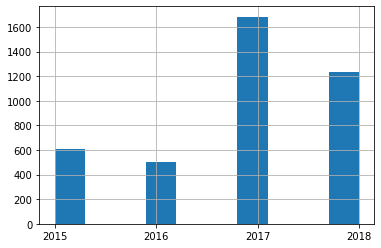

,platform
sales_year,
2015,606
2016,502
2017,1683
2018,1235


In [10]:
plt.xticks([2015, 2016, 2017, 2018])
games_data.sales_year.hist()
plt.show()
games_data.pivot_table(index='sales_year', values='platform', aggfunc = 'count')

В 2017 было продано наибольшее количество игр (1683).

Построим распределение количества игр с отзывом и без по годам продажи.

Игры с отзывом:
            platform
sales_year          
2015             225
2016             232
2017             773
2018             582 

Игры без отзыва:
            platform
sales_year          
2015             381
2016             270
2017             910
2018             653


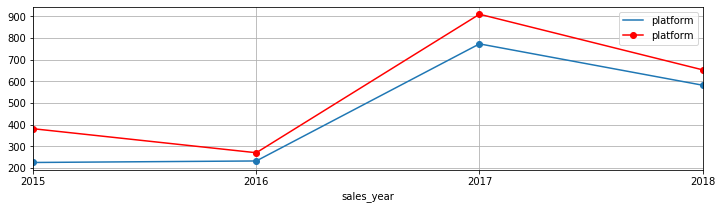

In [11]:
# игры с отзывом
ax = games_data[games_data['critic_score'].isna() == False]\
    .pivot_table(index='sales_year', values='platform', aggfunc = 'count')\
    .plot(grid=True, figsize=(12, 3), style ='o-')

print('Игры с отзывом:')
print(games_data[games_data['critic_score'].isna() == False]\
    .pivot_table(index='sales_year', values='platform', aggfunc = 'count'),'\n')

# игры без отзыва
games_data[games_data['critic_score'].isna() == True]\
    .pivot_table(index='sales_year', values='platform', aggfunc = 'count')\
    .plot(grid=True, figsize=(12, 3), style ='ro-', ax = ax, xticks = [2015,2016,2017,2018])

print('Игры без отзыва:')
print(games_data[games_data['critic_score'].isna() == True]\
    .pivot_table(index='sales_year', values='platform', aggfunc = 'count'))

Независимо от года, количество проданных игр без отзыва (без оценки критиков) больше, чем кол-во проданных игр с отзывом. Также, можно сделать вывод о том, что количество игр с отзывом (с оценкой критиков) меньше половины всех проданных игр.

Построим график для суммы продаж каждого года.

Суммарные продажи (в сотнях тысяч):
            sales_overall
sales_year               
2015              20358.0
2016               9615.0
2017              67696.0
2018              52313.0


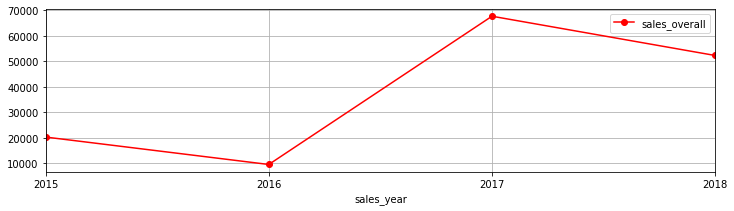

In [12]:
games_data.pivot_table(index='sales_year', values='sales_overall', aggfunc = 'sum')\
    .plot(grid=True, figsize=(12, 3), style ='ro-', xticks = [2015,2016,2017,2018])

print('Суммарные продажи (в сотнях тысяч):')
print(games_data.pivot_table(index='sales_year', values='sales_overall', aggfunc = 'sum'))

В 2017 было продано наибольшее количество копий игр (6.769.600.000).

Построим диаграмму размаха для значений общих продаж.

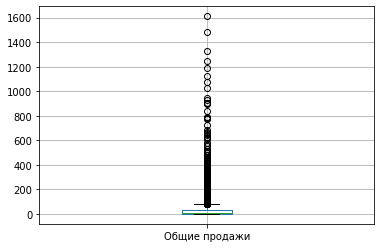

In [13]:
games_data.plot(y = 'sales_overall', kind = 'box', grid = 'True', label = 'Общие продажи')

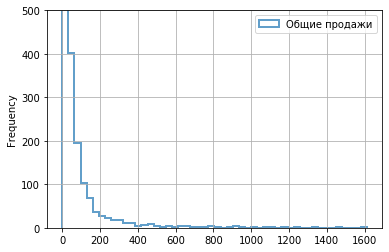

In [14]:
games_data.plot(y = 'sales_overall', kind = 'hist', grid = 'True', bins = 50, \
                          label = 'Общие продажи', histtype = 'step', linewidth = 2, alpha = 0.7, ylim = (0, 500))

In [15]:
games_data.sales_overall.describe()

count    4026.000000
mean       37.253353
std        99.359061
min         0.000000
25%         0.000000
50%         8.000000
75%        31.000000
max      1611.000000
Name: sales_overall, dtype: float64

По диаграмме размаха сложно сделать какой-либо вывод, но судя по характеристикам распределения, среднее кол-во проданных копий игры - 3.7 млн.

Определим платформу с наибольшим количеством проданных копий игр.

In [16]:
games_data.pivot_table(index='platform', values='sales_overall', aggfunc = 'sum')\
          .sort_values(by = 'sales_overall', ascending = False).head()

,sales_overall
platform,
X360,34390.0
PS3,33136.0
PS4,24983.0
XOne,14471.0
3DS,14392.0


На платформе X360 было продано наибольшее количество копий игр ~3.4 млрд. 

Найдём, игр какого жанра больше всего.

In [17]:
games_data.pivot_table(index='genre', values='sales_overall', aggfunc = 'count')\
          .sort_values(by = 'sales_overall', ascending = False).head()

,sales_overall
genre,
Action,1270
Role-Playing,467
Adventure,410
Sports,389
Misc,375


Больше всего игр в жанре Action - 1270 шт.

In [18]:
pd.set_option('display.max_rows', 10)

Найдём игры с самой высокой и самой низкой оценкой от критиков. Несмотря на то, что в наборе данных встречаются игры с одинаковым ID, будем считать такие игры разными, потому что они вышли на разных платформах.

In [19]:
games_data[games_data['critic_score'].isna() == False]\
          .sort_values(by = 'critic_score', ascending = False)

,platform,sales_year,genre,sales_online,sales_offline,critic_score,user_score,rating,game_id,sales_overall
0,PS3,2017,Action,702.0,909.0,97.0,8.2,M,20838,1611.0
9,PS4,2018,Action,396.0,631.0,97.0,8.3,M,28618,1027.0
44,XOne,2018,Action,281.0,219.0,97.0,7.9,M,39055,500.0
1,X360,2017,Action,966.0,514.0,97.0,8.1,M,48673,1480.0
19,X360,2017,Role-Playing,505.0,279.0,96.0,8.4,M,29673,784.0
...,...,...,...,...,...,...,...,...,...,...
2121,X360,2017,Sports,8.0,3.0,21.0,5.0,T,18203,11.0
2415,XOne,2015,Sports,3.0,5.0,20.0,3.1,E,42977,8.0
2127,PS4,2015,Sports,4.0,6.0,19.0,3.4,E,12797,10.0
2812,X360,2017,Racing,4.0,1.0,19.0,1.3,M,11902,5.0


Самую высокую оценку от критиков (97/100) имеют игры с ID:
- 20838;
- 28618 (на платформе PS4);
- 39055;
- 48673.

Самую низкую оценку от критиков (13/100) имеет игра с ID 28618 (на платформе PS3).

Возможно в наборе данных имеется ошибка, поскольку игра с одинаковым ID с изменением года продажи и платформы изменила и жанр. Требуется уточнение.

Найдём игры с самой высокой и самой низкой оценкой от пользователей. 

In [20]:
games_data[games_data['user_score'].isna() == False]\
          .sort_values(by = 'user_score', ascending = False)

,platform,sales_year,genre,sales_online,sales_offline,critic_score,user_score,rating,game_id,sales_overall
2348,PSV,2015,Adventure,0.0,3.0,86.0,9.3,M,38270,3.0
639,PC,2015,Role-Playing,21.0,46.0,93.0,9.3,M,12365,67.0
77,PS4,2015,Role-Playing,102.0,213.0,92.0,9.2,M,43575,315.0
339,XOne,2015,Role-Playing,69.0,50.0,91.0,9.2,M,10495,119.0
2277,PSV,2017,Adventure,4.0,4.0,83.0,9.2,M,27691,8.0
...,...,...,...,...,...,...,...,...,...,...
2321,X360,2017,Shooter,7.0,2.0,43.0,1.2,M,24620,9.0
3026,PS3,2017,Racing,2.0,1.0,13.0,1.0,M,28618,3.0
2695,DS,2017,Platform,6.0,0.0,NaN,0.9,E,14384,6.0
1739,X360,2016,Sports,14.0,2.0,NaN,0.7,E,28773,16.0


Самую высокую оценку от пользователей (9.3/10) имеют игры с ID:
- 38270;
- 12365.

Самую низкую оценку от пользователей (0.2/10) имеет игра с ID 23493.

In [21]:
pd.set_option('display.max_rows', None)

Рассмотрим 2 набора значений - оценка пользователей и оценка критиков. Найдём их дисперсии и коэффициент корреляции. Для возможности сравнения умножим оценки пользователей на 10.

# Комментарий наставника
Не обязательно проверять на равенство логические переменные. Варианты:
`games_data[(games_data['critic_score'].isna())] ` и `games_data[(games_data['critic_score'].isna() == True) ` - эквивалентны. 
Для False можно использовать отрицание:
`games_data[~(games_data['critic_score'].isna())] `

In [22]:
# для новой таблицы выберем те игры, у которых есть и оценка критиков и оценка пользователей
games_with_scores = games_data[(games_data['critic_score'].isna() == False) & (games_data['user_score'].isna() == False)]\
[['game_id', 'critic_score', 'user_score']]

In [23]:
# приведем столбец с оценками критиков к целочисленному типу
games_with_scores['critic_score'] = games_with_scores['critic_score'].astype('int')

In [24]:
# умножим оценки пользователей на 10 и приведем данные к целочисленному типу
games_with_scores['user_score'] = games_with_scores.apply(lambda x: x['user_score']*10, axis = 1).astype('int')

In [25]:
games_with_scores.head()

,game_id,critic_score,user_score
0,20838,97,82
1,48673,97,81
2,17801,88,34
5,28109,83,53
6,43830,83,48


In [26]:
print('Дисперсия оценок пользователей', np.var(games_with_scores['user_score']),'\n')
print('Дисперсия оценок критиков', np.var(games_with_scores['critic_score']),'\n')
print('Коэффициент корреляции между оценками критиков и пользователей',\
      games_with_scores['user_score'].corr(games_with_scores['critic_score']))

Дисперсия оценок пользователей 211.36359123329527 

Дисперсия оценок критиков 169.6273799783731 

Коэффициент корреляции между оценками критиков и пользователей 0.5348532967085243


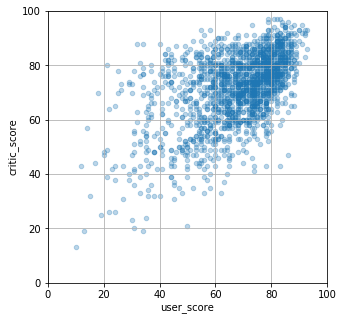

In [27]:
games_with_scores.plot(x='user_score', xlim=(0,100),\
                    y='critic_score', ylim=(0, 100),\
                    kind='scatter', figsize=(5, 5),\
                    grid=True, alpha = 0.3)

Коэффициент корреляции равен 0.53, что говорит о средней линейной зависимости между оценками критиков и пользователей.

## 4. Портрет пользователя для онлайн и офлайн продаж
Для покупателей интернет-магазина и сети розничных магазинов определите:

- топ-5 предпочтительных жанров;
- в какие года пользователи были наиболее активны (больше всего покупали игры);
- топ-5 предпочтительных платформ;
- какой рейтинг ESRB встречается чаще всего (наиболее частотная категория).

In [28]:
games_data.head()

,platform,sales_year,genre,sales_online,sales_offline,critic_score,user_score,rating,game_id,sales_overall
0,PS3,2017,Action,702.0,909.0,97.0,8.2,M,20838,1611.0
1,X360,2017,Action,966.0,514.0,97.0,8.1,M,48673,1480.0
2,X360,2017,Shooter,904.0,424.0,88.0,3.4,M,17801,1328.0
3,PS4,2015,Shooter,603.0,586.0,NaN,NaN,NaN,12200,1189.0
4,3DS,2017,Role-Playing,528.0,419.0,NaN,NaN,NaN,11432,947.0


Определим топ-5 предпочтительных жанров с наибольшим суммарным количеством проданных копий онлайн и оффлайн. 

In [29]:
print('Жанры (онлайн продажи):')
print(games_data.pivot_table(index='genre', values='sales_online', aggfunc = 'sum')\
          .sort_values(by = 'sales_online', ascending = False).head(),'\n')

print('Жанры (оффлайн продажи):')
print(games_data.pivot_table(index='genre', values='sales_offline', aggfunc = 'sum')\
          .sort_values(by = 'sales_offline', ascending = False).head(),'\n')

Жанры (онлайн продажи):
              sales_online
genre                     
Action             23092.0
Shooter            19443.0
Sports             10870.0
Role-Playing        8378.0
Misc                6969.0 

Жанры (оффлайн продажи):
              sales_offline
genre                      
Action              19912.0
Shooter             14802.0
Sports               8848.0
Role-Playing         6230.0
Racing               4058.0 



In [30]:
print('Года (онлайн продажи):')
print(games_data.pivot_table(index='sales_year', values='sales_online', aggfunc = 'sum')\
          .sort_values(by = 'sales_online', ascending = False).head(),'\n')

print('Года (оффлайн продажи):')
print(games_data.pivot_table(index='sales_year', values='sales_offline', aggfunc = 'sum')\
          .sort_values(by = 'sales_offline', ascending = False).head(),'\n')

Года (онлайн продажи):
            sales_online
sales_year              
2017             39244.0
2018             28580.0
2015             10686.0
2016              4493.0 

Года (оффлайн продажи):
            sales_offline
sales_year               
2017              28452.0
2018              23733.0
2015               9672.0
2016               5122.0 



In [31]:
print('Платформы (онлайн продажи):')
print(games_data.pivot_table(index='platform', values='sales_online', aggfunc = 'sum')\
          .sort_values(by = 'sales_online', ascending = False).head(),'\n')

print('Платформы (оффлайн продажи):')
print(games_data.pivot_table(index='platform', values='sales_offline', aggfunc = 'sum')\
          .sort_values(by = 'sales_offline', ascending = False).head(),'\n')

Платформы (онлайн продажи):
          sales_online
platform              
X360           22680.0
PS3            16826.0
PS4            10874.0
XOne            9312.0
3DS             8265.0 

Платформы (оффлайн продажи):
          sales_offline
platform               
PS3             16310.0
PS4             14109.0
X360            11710.0
3DS              6127.0
PC               5670.0 



In [32]:
print('Наиболее частый рейтинг:')
print(games_data.pivot_table(index='rating', values='sales_online', aggfunc = 'count')\
          .sort_values(by = 'sales_online', ascending = False).head(),'\n')

Наиболее частый рейтинг:
        sales_online
rating              
M                622
E                619
T                616
E10+             456
EC                 1 



Для покупателей онлайн:

топ-5 предпочтительных жанров:
1. Action;      
2. Shooter;     
3. Sports;      
4. Role-Playing;
5. Misc;        

топ-5 предпочтительных платформ:
1. X360; 
2. PS3;  
3. PS4;  
4. XOne; 
5. 3DS.  

Для покупателей оффлайн:

топ-5 предпочтительных жанров:
1. Action;      
2. Shooter;     
3. Sports;      
4. Role-Playing;
5. Racing;      

топ-5 предпочтительных платформ:
1. PS3;    
2. PS4;    
3. X360;   
4. 3DS;
5. PC.

Пользователи обеих категорий были наиболее активны в 2017 и 2018 годах. 

Наиболее часто встречающийся рейтинг игр - М (от 17 лет), однако рейтинги Е (для всех) и Т (13—19 лет) встречаются почти так же часто.

## 5. Проверка гипотез:

- средний пользовательский рейтинг платформ PS4 и PS3 одинаковый;
- средний пользовательский рейтинг жанров Action и Sports различается.

Пороговое значение alpha задайте самостоятельно.
Поясните:

- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

In [33]:
# для новой таблицы выберем те игры, у которых есть оценка пользователей
games_with_user_scores = games_data[games_data['user_score'].isna() == False]\
[['game_id', 'user_score', 'platform', 'genre']]
games_with_user_scores.head()

,game_id,user_score,platform,genre
0,20838,8.2,PS3,Action
1,48673,8.1,X360,Action
2,17801,3.4,X360,Shooter
5,28109,5.3,PS3,Shooter
6,43830,4.8,X360,Shooter


In [34]:
# средний пользовательский рейтинг игр на платформе PS3
games_with_user_scores.query('platform == "PS3"')['user_score'].mean()

6.612470023980816

In [35]:
# средний пользовательский рейтинг игр на платформе PS4
games_with_user_scores.query('platform == "PS4"')['user_score'].mean()

6.748249027237354

Сформулируем нулевую гипотезу: "Средний пользовательский рейтинг платформ PS4 равен среднему пользовательскому рейтингу платформы PS3".

In [36]:
# зададим критический уровень статистической значимости в 5%
alpha = .05 

results = st.ttest_ind(
    games_with_user_scores.query('platform == "PS3"')['user_score'], 
    games_with_user_scores.query('platform == "PS4"')['user_score'],
    equal_var = True)

print('p-значение:', results.pvalue)

p-значение: 0.26218390192537744


Уровень статистической значимости выше критического, делаем вывод о том, что средний пользовательский рейтинг на платформах PS3 и PS4 одинаков.

In [37]:
# средний пользовательский рейтинг игр жанра Action
games_with_user_scores.query('genre == "Action"')['user_score'].mean()

6.775903614457831

In [38]:
# средний пользовательский рейтинг игр жанра Sports
games_with_user_scores.query('genre == "Sports"')['user_score'].mean()

5.650813008130081

Сформулируем нулевую гипотезу: "Средний пользовательский рейтинг для игр жанров Action и Sports одинаков".

In [39]:
# зададим критический уровень статистической значимости в 5%
alpha = .05 

results = st.ttest_ind(
    games_with_user_scores.query('genre == "Action"')['user_score'], 
    games_with_user_scores.query('genre == "Sports"')['user_score'],
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 8.285648549432565e-19


Уровень статистической значимости значительно ниже критического. Вероятность того, что средние рейтинги для жанров Action и Sports одинаковы практически равна 0%. 

Отверграем нулевую гипотезу, делаем вывод об отличии среднего значения пользовательского рейтинга для игр жанров Action и Sports.

## 6. Общий вывод
Оформление: Задание выполните в Jupyter Notebook. Программный код заполните в ячейках типа code, текстовые пояснения — в ячейках типа markdown. Примените форматирование и заголовки.


Исходя из анализа приведенных данных, в будущих онлайн продажах стоит сосредоточиться на играх в жанрах:
1. Action;      
2. Shooter;     
3. Sports;      
4. Role-Playing;
5. Misc;

на платформах:
1. X360; 
2. PS3;  
3. PS4;  
4. XOne; 
5. 3DS.  

В будущих розничных продажах стоит сосредоточиться на играх в жанрах:
1. Action;      
2. Shooter;     
3. Sports;      
4. Role-Playing;
5. Racing; 

на платформах:
1. PS3;    
2. PS4;    
3. X360;   
4. 3DS;
5. PC.